The amount of data humanity generated in the years of 2014 and 2015 was equal to all that was generated in all of the previous years before. This new paradigm is sometimes called the age of Big Data and Internet of Things (IoT), in which data is not only being generated by individuals but also by "things". The energy sector is an important member of this new era because one of these "things" is the smart meter — a small computer that measures the amount of energy being consumed by a house, building or factory - in real time. 

All this data offers a unique opportunity to better understand the behavior of energy consumers. This can be achieved by utilizing artificial intelligence tools that segment consumers into clusters of similarity. Each cluster contains energy consumption patters that are similar to each other - this is sometimes called an "energy footprint". In crude terms, it is the way one individual or family uses energy during the day. By segmenting energy profiles, utilities can determine specific tariffs according to the type of consumer. This, in turn, is a type of measure that can improve energy efficiency across the grid, which is of great importance in a context of a worldwide transition  to a low-carbon economy.

This mini-project applies a clustering algorithm (K-means) to segment electricity load profiles into clusters. The data of energy consumption is from the Pecan Street Energy Database, a project coordinated by the University of Texas at Austin in which more than 500 houses across the state of Texas participate and energy consumption is measured by smart meters every minute. The data used in the paper is for 216 households during July and August of 2015.

## Import necessary libraries

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3

## Get data from SQLite

In [2]:
# I stored the data that I retrieved from the Dataport Database into an SQLite database file. 
cwd = os.getcwd()
conn = sqlite3.connect(str(cwd) + "/dataport_sqlite") 
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

## Load result in a Pandas DataFrame

In [3]:
df = pd.DataFrame(data, columns=['id','date','energy_use'])
df.head() 
# id is the id of the house in the study and energy_use in 
# the amount of energy consumed during a 15 minute interval

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


In [4]:
print("The dataframe contains {:,} rows and {} columns".format(df.shape[0],df.shape[1]))

The dataframe contains 646,981 rows and 3 columns


The energy consumption measurements are spaced by 15 minutes.Column 'id' represents the id of the house, 'date' the date and time of measurement and 'energy_use' the measured power in kW.

## Cleaning the data

### We got missing values in the form of empty strings

In [5]:
df = df.replace('',np.nan)
df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

### Let's remove them

In [6]:
df = df.dropna()

### Transform datatypes

In [7]:
# transfrom load consumption values into into float
df.loc[:,'energy_use'] = df.energy_use.astype(float) 
# transfrom id column to integer
df.loc[:,'id'] = df['id'].astype(int) 
# transfrom date into datetime
df.loc[:,'date'] = pd.to_datetime(df.date) 

### Create columns with an integer that represents the day of the month and the month of the year for each row

The data is not exactly in the way I want it. To be able to compare the similarities between each load profile I must have each of them stored in a single array. In other words, I want to have several arrays of load profiles for each day for any given house but I have all the data grouped into one single column. Creating columns with the day of the month and the month of the year as integers will facilitate the process of filtering.

In [8]:
# create a column that contains info if 
# the observation is on a weekday or a weekend
df.loc[:,'type_day'] = df.date.apply(lambda x: x.isoweekday()) 

# create a column of the day of the 
# month for a particular observation
df.loc[:,'day_of_month'] = df.date.apply(lambda x: x.day) 

# create a column of the month 
# of the year for a particular observation
df.loc[:,'month'] = df.date.apply(lambda x: x.month) 

# sort values 
df = df.sort_values(['id', 'date'], ascending=[True, True])
df = df.reset_index()

### Filter the weekends 

Excluding the load-profiles of weekends makes our dataset more homogeneous and easier for cluster creation.

In [9]:
# select only weekdays
df = df[(df['type_day'] != 6) & (df['type_day'] != 7)] 

###  How many differenet homes in the dataset?

In [10]:
households = np.unique(df['id'])   
print("there are",np.count_nonzero(households),"different households") 

there are 216 different households


###  Define function that parses the one column dataset and returns a matrix of load profiles. Each row represents one load profile for a particular household.

In [11]:
def extract_daily_load(df):
    """parses the time-series to extract load measurements 
     from one particular day for one particular house"""
    
    load_data = []
    
    for house in households:
        # separete loads by household
        data_one_house = df[df['id'] == house] 
        
        for month in range(7,8):
            # and this separetes loads by day
            for day in range(1,31): 
                one_day_load = (data_one_house
                                [data_one_house['month'] == month]
                                [data_one_house['day_of_month'] == day])
                # only grab daily loads with 96 
                # observations (some have missing values)
                if len(one_day_load) == 96: 
                    load_data.append(one_day_load.energy_use)
    return load_data

In [12]:
load_data = extract_daily_load(df)

### Transform list of lists into numpy array 

Numpy arrays are optimized for computation. 

In [13]:
# transform list of lists into numpy array
load_data_np = np.array(load_data) 

print("There are",load_data_np.shape[0],
      "dayly-loads in the dataset. Each containing",
      load_data_np.shape[1] ,"load measurements.")

There are 4702 dayly-loads in the dataset. Each containing 96 load measurements.


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data.
The data wil be scaled into values between 0 and 1. 

In [14]:
from sklearn.preprocessing import normalize
load_data_scaled = normalize(load_data)
load_data_scaled                                                

array([[ 0.07919184,  0.04391111,  0.07921199, ...,  0.05013277,
         0.03978909,  0.04345086],
       [ 0.03932796,  0.10140809,  0.14347421, ...,  0.05112183,
         0.0595932 ,  0.05774141],
       [ 0.05915546,  0.15391654,  0.22118042, ...,  0.06843618,
         0.07248123,  0.12173624],
       ..., 
       [ 0.13219142,  0.0292397 ,  0.01633352, ...,  0.09091795,
         0.00676467,  0.00673697],
       [ 0.01262715,  0.00986974,  0.00595242, ...,  0.00329519,
         0.10633697,  0.10918402],
       [ 0.0729647 ,  0.00425861,  0.00668233, ...,  0.13614554,
         0.06539231,  0.01496677]])

## How does a load profile look like?

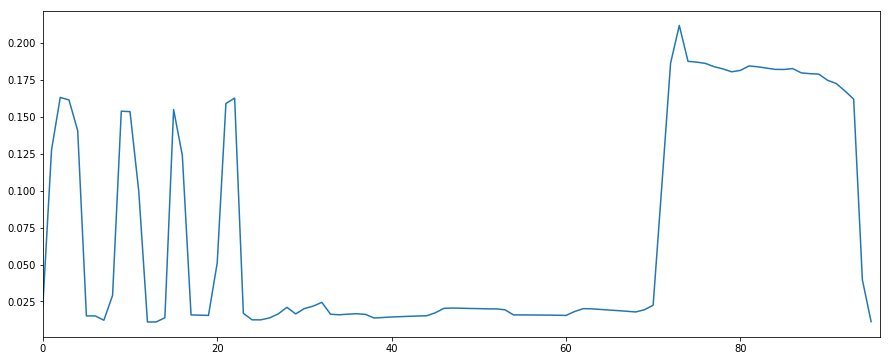

In [15]:
pylab.rcParams['figure.figsize'] = 15, 6  
x = load_data_scaled[123]
plt.plot(x)
plt.xlim(0,96)
plt.show()

### How would all the 4702 load curves look like ploted together?

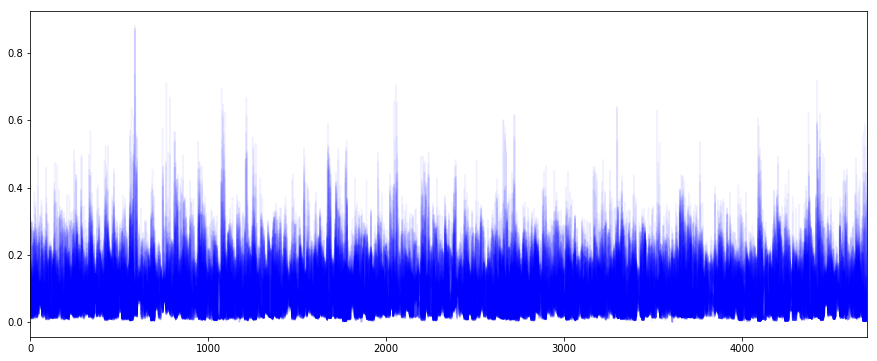

In [16]:
pylab.rcParams['figure.figsize'] = 15, 6  
plt.xlim(0,4702)
plt.plot(load_data_scaled, color='blue',alpha=0.05)
plt.show()

Quite messy huh? The creation of clusters will alow us to find structure that is not visible in all of those curves. 

## Perform cluster analysis  with K-means

The goal of clustering is to find subgroups or clusters in a data-set. Each subgroup contains elements that are similar to each other, thus one crucial point is to properly define what is similarity between two objects. One of the most popular algorithms used in cluster analysis the K-means.

The K-means algorithm belongs to a class of clustering technique known as *prototype clustering*. Each clusters is represented by a **centroid** *average* of similar points with continuous features. 

Given a set of clusters $C_1,...,C_K$, the K-means algorithm aims to minimize the *within-cluster variation* ($W(C_k)$), which is a measure of of the amount by which the observations within a clusters differ from each other. Therefore the problem resolves to:

$$\overset{minimize}{C_1,...,C_K}\left\{ \sum\limits_{j=1}^K W(C_k) \right\}$$

In which $W(C_k)$ is the squared euclidean distance between two vectors (x,y) in an IR$^p$, given by: 
$$W(C_k)=\frac{1}{|C_k|} \sum\limits_{i,j\epsilon C_k} \sum\limits_{j=1}^p (x_{ij}-y_{ij})^2 $$

where $|C_k|$ is the number of observation in each cluster. In other words, "the within cluster variation  for the kth cluster is the sum of all  of the pairwise  squared Euclidean distances between the observations in the kth cluster, divided by the total number of observations in each cluster". One of the challenges to find the optimum clusters is that there are $K^n$ ways to segment $n$ observations into $K$ clusters. However,the K-means algorithm provides an elegant, yet simple, solution to find the local optimum. The algorithm is can be summarized by the following four steps:

1. Randomly select $k$ centroids from the sample points as initial cluster centers;
2. Assign each sample to the nearest centroid $\mu^{(j)}$, $j \epsilon \left\{ 1,...,k \right\}$ (where nearest is measured by the square of the euclidean distance); 
3. Move the centroids to the center of the samples that were assigned to it; 
4. Repeat the steps 2 and 3 until the cluster assignment do not change or a user-defined tolerance or a maximum number of ierations is reached.

K-means clustering derives its name from the fact that in Step (2), the cluster centroids are computed as the mean of the observations assigned to each cluster.

## Optimal number of clusters

To determine the optimal number of clusters $k$ it is necessary to use the within-cluster $W(C_k)$(distortion) as a metric to compare the performance of different k-means clustering. If $k$ increases the distortion will decrease because the samples will be closer to the centroids the are assigned to. The **elbow method** is often used to estimate the optimal $k$ as it's as graphical tool that helps to visualize  the process. The main idea is to identify the value o $k$ where the distortion begins to increase most rapidly. 

## Execute the model

In [17]:
from sklearn.cluster import KMeans

In [18]:
class PlotClusters():
     
    def __init__(self,data):
        self.means = [] # list will contain the centroid of each cluster
        self.data = data

    def elbow_method(self,n_clusters):

        pylab.rcParams['figure.figsize'] = 10, 6  
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, init='k-means++', n_init=10, max_iter = 300, random_state = 0)
            km.fit(self.data)
            distortions.append(km.inertia_)
        # plot
        plt.plot(range(1,n_clusters), distortions, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.show() 
        
    def fit(self,n_clusters):
        
        self.n_clusters = n_clusters
        model = KMeans(self.n_clusters)
        self.prediction = model.fit_predict(self.data)
        count_list = {}
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]

        for cluster in self.cluster_names:
            count = 0
            for cluster_prediction in self.prediction:
                if cluster_prediction == int(cluster):
                    count += 1 
            count_list[cluster] = count
        return count_list

    def plot(self):
        
        cluster_names = [str(x) for x in range(self.n_clusters)]
        pylab.rcParams['figure.figsize'] = 60, 80

        for i in range(0,self.n_clusters):
            all_data=[] # will keep track 
            
            for x,y in zip(self.data,self.prediction):
                    if y == i:
                        all_data.append(x)
                        # plot   
                        plt.subplot(4,2,i+1)
                        plt.plot(x,alpha=0.03,color="blue")
                        plt.ylim(0,0.6)
                        plt.xlim(0,96)
                        plt.title('Cluster {}'.format(str(i+1)+':{} daily load profiles'.format(str(self.cluster_names[i]))))

            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, alpha=0.3, color="black",linewidth=4)
        plt.show()
        
        
    def count_loads_in_cluster(self):

        count_list = {}
        clusters = [str(x) for x in range(self.n_clusters)]

        for cluster in clusters:
            count = 0
            for cluster_prediction in self.prediction:
                if cluster_prediction == int(cluster):
                    count += 1 
            count_list[cluster] = count
        return count_list

    def energy_fingerprints(self):
        
        pylab.rcParams['figure.figsize'] = 20, 12 
        for i,item in enumerate(self.means):
            plt.plot(item,alpha = 0.7, label = "cluster {}".format(str(i+1)))
            plt.xlim(0,96)
        plt.legend()
        plt.show()
        
        

### Create instance of PlostClusters

In [19]:
model = PlotClusters(load_data_scaled)

### Run the elbow method

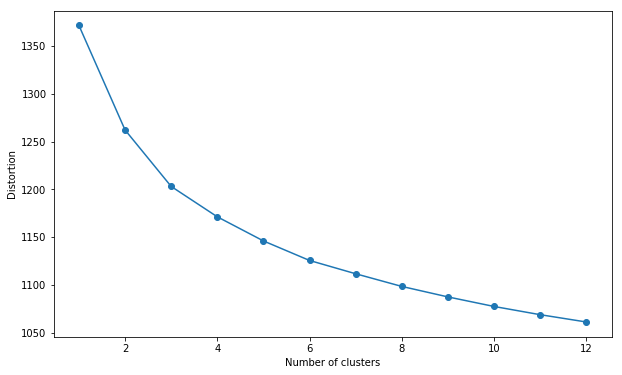

In [20]:
model.elbow_method(n_clusters=13)

The elbow method plot shows the dispersion for a k-means with 1 to 10 clusters. The amount of dispersion starts to accelerate at K = 3, so this is considered the optimal number of clusters

### Fit the model

In [21]:
model.fit(n_clusters = 4)

{'0': 686, '1': 1984, '2': 914, '3': 1118}

### Plot clusters

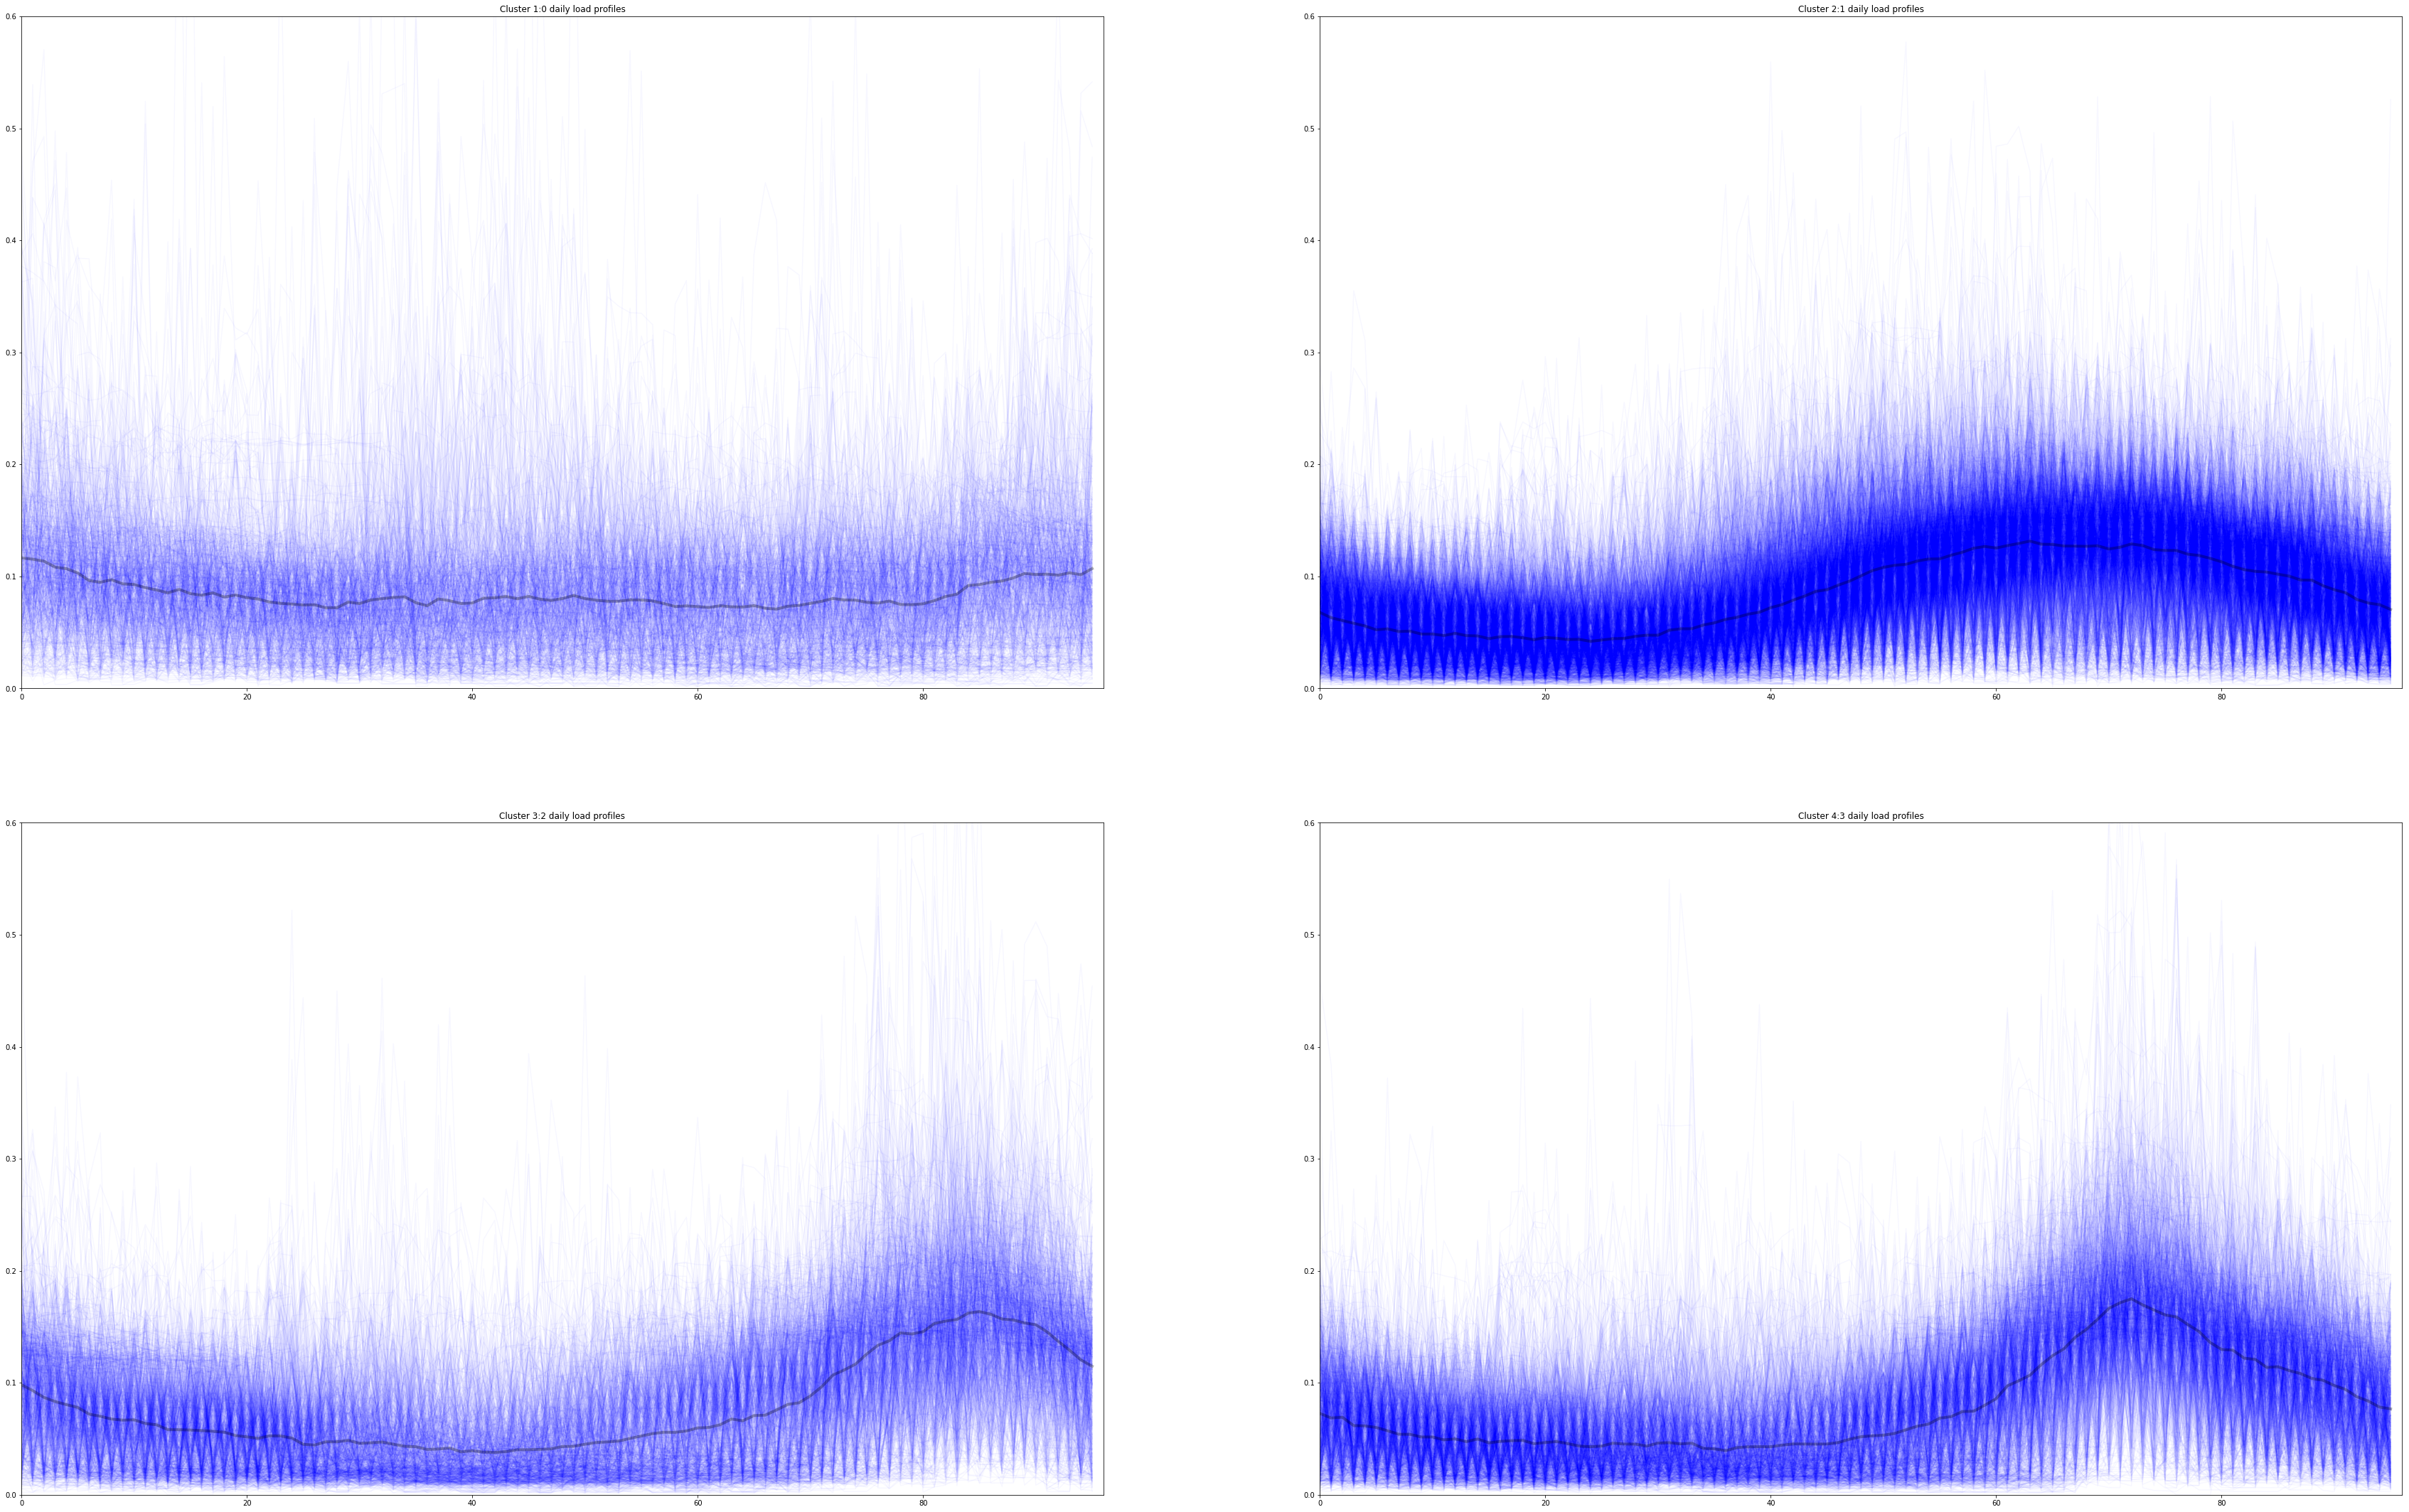

In [22]:
model.plot()

## The energy fingerprints in one plot

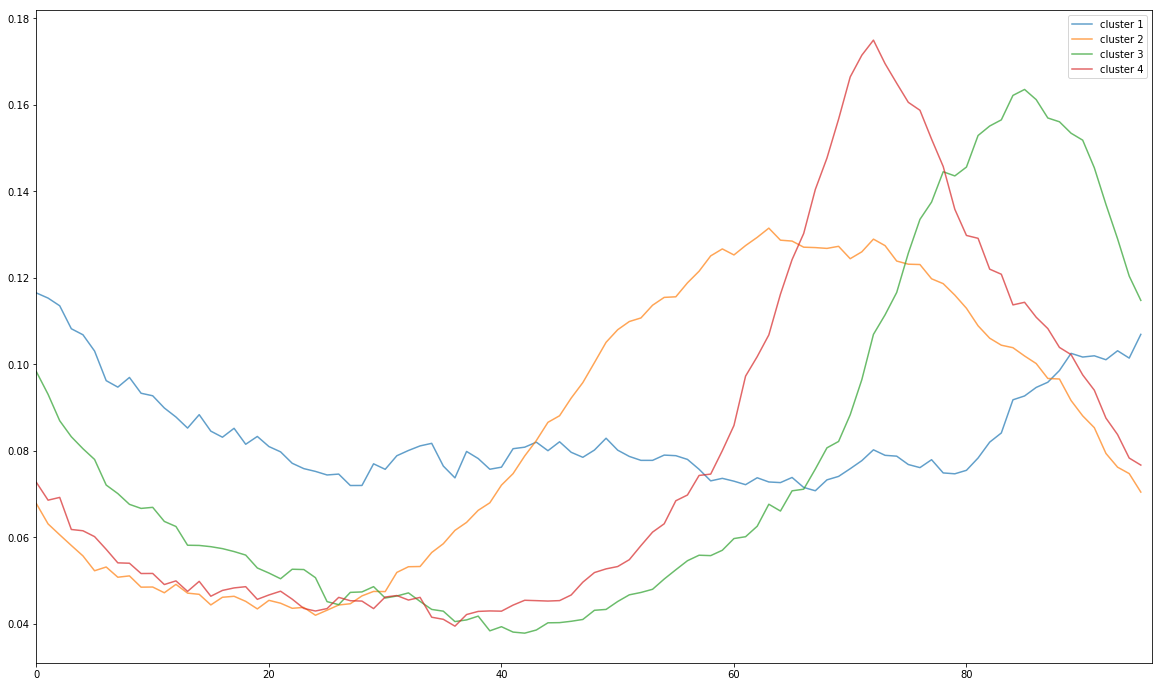

In [23]:
model.energy_fingerprints()

#### So there we have it. K-means found three different ways people  of 216 households consumed energy during the summer of 2015 in Austin-TX. 